Coffee 1 = 0.02 - 0.012*dfc["ballpark_fortification"] (ALL SEASONS)
Coffee 2 = 0.01875 - 0.0075*dfc["ballpark_fortification"] (ALL SEASONS)
Flooding = 0.016 - 0.001*dfc["ballpark_fortification"] (SEASON 12)
           0.03 - 0.0245*dfc["ballpark_fortification"] (SEASON 13)
           0.019 - 0.020*dfc["ballpark_fortification"] (SEASON 14)
           0.013 - 0.012*dfc["ballpark_fortification"] (SEASON 15, 16, 17)
           0.0145 - 0.01*dfc["ballpark_fortification"] (SEASON 18, 19)

Salmon: 0.15 - 0.1*dfc["ballpark_fortification"] (SEASON 15, 16)
        0.1375 - 0.1*dfc["ballpark_fortification"] (SEASON 17, 18, 19)

Reverb: 

Blooddrain: 0.00065 - 0.001*dfc["ballpark_fortification"] (SEASON 12, 13, 14, 15, 16)
            0.00125 - 0.00125*dfc["ballpark_fortification"] (SEASON, 17, 18, 19)
Siphon: Anything between Blooddrain threshold and 0.0025

Feedback: 0.0001 - 0.0001*dfc["ballpark_fortification"]
FLICKERING: 0.02 or 0.025
FLIICKERRRIIING: 0.055, probably a bit higher like 0.075

Peanut: 0.0006 - 0.00055 * dfc["ballpark_fortification"] or 0.0005 - 0.000325 * dfc["ballpark_fortification"] (ALL SEASONS)

Glitter: 0.007 - 0.0055*dfc["ballpark_fortification"] (SEASON 16, currently only have misses in Season 17 and no actual glitter games in S18 or S19)

Polarity: 0.035 - 0.025*dfc["ballpark_fortification"] (SEASON 19)

Eclipse:  0.00045 - 0.0004*dfc["ballpark_fortification"] (SEASON 14, 15,16,17,18,19)


In [83]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [362]:
all_files = glob.glob("../roll_data/*-weatherproc.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [11,12,13,14,15,16,17,18]
df = df[df['season'].isin(seasons)]
len(df)

513387

In [363]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]

coffee_events = ("Bean", "NoBean")
coffee2_events = ("Refill", "NoRefill")
flooding_events = ("Swept", "NoSweep")
reverb_events = ("Shuffle", "NoShuffle")
bloodrain_events = ("Drain", "NoDrain") 
feedback_events = ("Swap", "NoSwap")
peanut_events = ("Allergy", "NoAllergy")
salmon_events = ("Salmon", "NoSalmon")
eclipse_events = ("Burn", "NoBurn")
glitter_events = ("LootDrop", "NootDrop")
polarity_events = ("Switch", "NoSwitch")

include_events = eclipse_events

dfc = dfc[dfc["event_type"].astype(str).isin(include_events)]

In [364]:

X = dfc[
    [
        "roll",
        "passed",
        "ballpark_fortification"
    ]
].copy()
#X = X[X["roll"] > 0.001]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = None
pins = [ 
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[66425     0]
 [    1    19]]
1 outliers
0.9999849499586124
0.00044657916677825224


[(1.0, 'roll'), (0.0003989030091810781, 'ballpark_fortification')]

In [365]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

66425
20


In [384]:

dfc["threshold"] = 0.00045 - 0.0004*dfc["ballpark_fortification"]

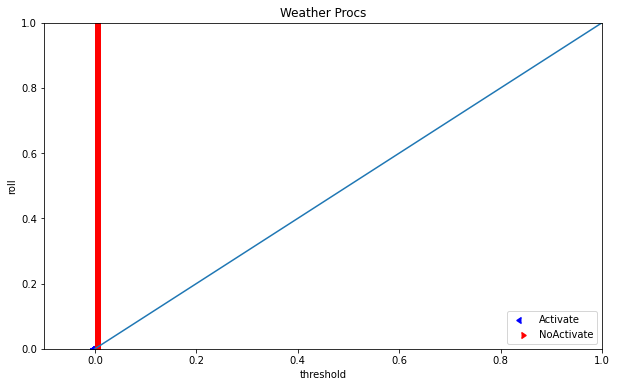

In [385]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Activate", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoActivate", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Weather Procs")
ax.set_xlim([-0.1, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,weather,event_type,season,roll,threshold,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
202849,-3.019121e-07,Weather.ECLIPSE,NoBurn,13,0.000163,0.000163,Jesús Koch,Gabriel Griffith,ALTERNATE,<NA>,HIGH_PRESSURE,LOVE,5,871c2227-e3de-45d9-b2fa-cd53323ca01d,213


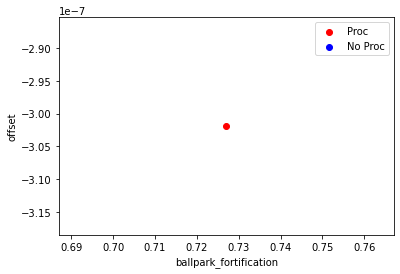

In [386]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_fortification"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Proc")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="No Proc")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "season",
       "roll", "threshold", 
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [353]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.00022437805880382025
3.781289435189628e-05
